In [53]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score

from mfbml.metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
from mfbml.methods.bayes_neural_nets import BNNWrapper
from mfbml.methods.mf_dnn_lr_bnn import MFDNNBNN
from mfbml.methods.mf_dnn_bnn import SequentialMFBNN
# fix the random seed for reproducibility
seed = 1999
np.random.seed(seed)
torch.manual_seed(seed)

In [54]:
# read the data
data = pd.read_pickle("data.pkl")
# extract dataset
samples = data["samples"]
hf_samples = samples["hf"]
lf_samples = samples["lf"]
hf_responses = data["responses_lf1"]["hf"]
responses_lf1 = data["responses_lf1"]
responses_lf2 = data["responses_lf2"]
responses_lf3 = data["responses_lf3"]
test_samples = data["test_samples"]
test_hf_responses_noiseless = data["test_hf_responses_noiseless"]
test_hf_responses = data["test_hf_responses"]
test_lf1_responses = data["test_lf1_responses"]
test_lf2_responses = data["test_lf2_responses"]
test_lf3_responses = data["test_lf3_responses"]

In [55]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 10000,
    "print_iter": 100,
    "data_split": False,
}
hf_train_config = {
    "num_epochs": 30000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 20000,
}

In [56]:
# create the MFDNNBNN object
smf_bnn_lf1 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf1.train(
    samples=samples,
    responses=responses_lf2,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)
# save the model to the disk
with open("smf_bnn_lf2_50.pkl", "wb") as f:
    torch.save(smf_bnn_lf1, f)

No data split: use all data for training
epoch:  100 train loss:  0.8514726758003235
epoch:  200 train loss:  0.8511347770690918
epoch:  300 train loss:  0.8508942127227783
epoch:  400 train loss:  0.8507319688796997
epoch:  500 train loss:  0.8506328463554382
epoch:  600 train loss:  0.8505746126174927
epoch:  700 train loss:  0.8505282402038574
epoch:  800 train loss:  0.8504732847213745
epoch:  900 train loss:  0.8503977656364441
epoch:  1000 train loss:  0.850273847579956
epoch:  1100 train loss:  0.8499467968940735
epoch:  1200 train loss:  0.8473073244094849
epoch:  1300 train loss:  0.8262284398078918
epoch:  1400 train loss:  0.7696188688278198
epoch:  1500 train loss:  0.7097434997558594
epoch:  1600 train loss:  0.685075581073761
epoch:  1700 train loss:  0.6378404498100281
epoch:  1800 train loss:  0.5878780484199524
epoch:  1900 train loss:  0.5439889430999756
epoch:  2000 train loss:  0.513241171836853
epoch:  2100 train loss:  0.4982086718082428
epoch:  2200 train loss:  

In [57]:
# read the results
with open("smf_bnn_lf2_50.pkl", "rb") as f:
    model = torch.load(f)

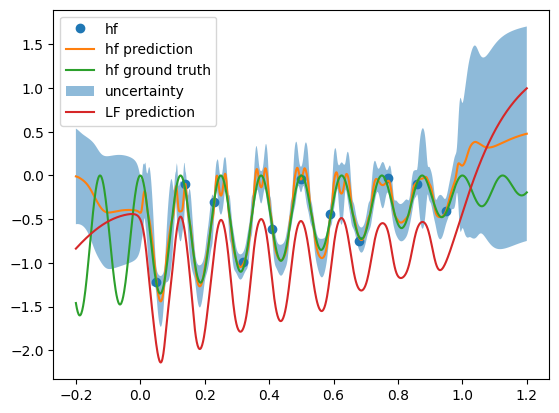

In [58]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf1_hy,
    smf_bnn_lf1_epistemic,
    smf_bnn_lf1_total_unc,
    smf_bnn_lf1_aleatoric,
) = model.predict(x=test_samples)
# get lf predictions
smf_bnn_lf1_y = model.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
# ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    label="LF prediction"
)
ax.legend()
plt.show()